In [2]:
from astropy.io import fits
from astropy.visualization import ZScaleInterval
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from astropy.wcs import WCS
import pandas as pd

### WCS Check

In [2]:
hdu = fits.open('ps_NGC884_B_8min_stacked.fit')
sci = hdu[0].data
hdr = hdu[0].header

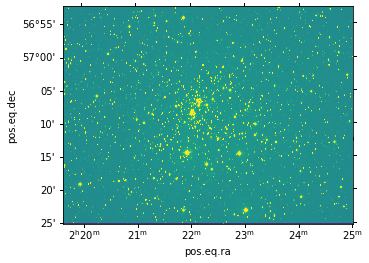

In [3]:
wcs = WCS(hdr)
ax = plt.subplot(projection=wcs)
vmin, vmax = ZScaleInterval().get_limits(sci)
# plt.figure(dpi=200)
ax.imshow(sci, origin='lower', vmin=vmin, vmax=vmax)

plt.show()

In [4]:
def plot_image(data):
    vmin, vmax = ZScaleInterval().get_limits(data)
    plt.figure(dpi=200)
    plt.imshow(data, origin='lower', vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.show()

### SExtractor

In [6]:
SEx_files = sorted(glob('*.ASC'))
print(SEx_files)
namelist = []
for i in range(len(SEx_files)):
    sym="_"
    namelist.append(sym.join(SEx_files[i].split('_')[2:5]))
print(namelist)
namelist[:8]


['pos_calibrated_r_M22_B_30sec_stacked.ASC', 'pos_calibrated_r_M22_B_8min_stacked.ASC', 'pos_calibrated_r_M22_V_30sec_stacked.ASC', 'pos_calibrated_r_M22_V_5min_stacked.ASC', 'pos_calibrated_r_M22_V_5sec_stacked.ASC']
['r_M22_B', 'r_M22_B', 'r_M22_V', 'r_M22_V', 'r_M22_V']


['r_M22_B', 'r_M22_B', 'r_M22_V', 'r_M22_V', 'r_M22_V']

In [7]:
class StarCluster:
    def __init__(self, filename):
        self.filename = filename
        self.name = filename.split('_')[2]
        self.filter = filename.split('_')[3]
        if filename.split('_')[4]=='1sec':
            self.exptime = 1
        elif filename.split('_')[4]=='5sec':
            self.exptime = 5
        elif filename.split('_')[4]=='30sec':
            self.exptime = 30
        elif filename.split('_')[4]=='5min':
            self.exptime = 300
        elif filename.split('_')[4]=='8min':
            self.exptime = 480
        
    def get_data(self):
        with open(self.filename) as file:
            data = file.readlines()
            data = data[16:]
            rows = len(data)
            cols = len(data[0].split())
            numeric_data = np.zeros((rows, cols))
            for i, line in enumerate(data):
                numeric_data[i] = list(map(float, line.split()))
            self.data = numeric_data
    def get_star(self,SNr):
        SNR = self.data[:,17]/self.data[:,18]
        self.star = np.where(np.array(SNR)>=SNr)[0]
        self.mag = -2.5*np.log10(self.data[:,17])
        self.star_ra, self.star_dec = self.data[self.star,1], self.data[self.star,2]
        return self.star, self.mag
    def get_new_star(self,star):
        self.star_n = star
        self.mag_n = -2.5*np.log10(self.data[star,17])
        self.star_ra_n, self.star_dec_n = self.data[star,1], self.data[star,2]
    def write_reg(self,star):
        f = open(self.filename+"_reg.txt", 'w')
        f.write('# Region file format: DS9 version 4.1\n')
        f.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\n')
        f.write('fk5\n')
        for i in star:
            f.write('circle('+str(self.data[i,1])+','+str(self.data[i,2])+',1.500")\n')
        f.close()


In [8]:
ClusterP = {}
for i in range(len(SEx_files)):
    ClusterP[namelist[i]] = StarCluster(SEx_files[i])


In [10]:
class APASSStar:
    def __init__(self, filename):
        self.filename = filename
        self.name = filename.split('_')[0]
        
    def get_data(self):
        with open(self.filename) as file:
            df = pd.read_csv(self.filename)
            # print(df.info())
            df2 = df.dropna(subset=['radeg','decdeg'])
            data = (df2.to_numpy())
            self.data = data
    def get_star(self):
        Johnson_V,Johnson_B = self.data[:,4], self.data[:,7]
        apass_ra, apass_dec = self.data[:,0], self.data[:,2]
        self.V, self.B, self.ra, self.dec = Johnson_V, Johnson_B, apass_ra, apass_dec
    def write_reg(self):
        f = open(self.filename+"_reg.txt", 'w')
        f.write('# Region file format: DS9 version 4.1\n')
        f.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\n')
        f.write('fk5\n')
        for i in range(len(self.data[:,0])):
            f.write('circle('+str(self.data[i,0])+','+str(self.data[i,2])+',3.000")\n')
        f.close()

In [11]:
APASS_IF = {"name":['APASS_M22'],"filename":['M22_apass_279.108753333333_-23.9022436111111_0.5.csv']}
APASS = {}
for i in range(len(APASS_IF["name"])):
    APASS[APASS_IF["name"][i]] = APASSStar(APASS_IF["filename"][i])

In [12]:
def crossmatch(apass_ra,apass_dec,star_ra,star_dec,imp):
    search_apass_index = []
    search_star_index = []
    for i in range(len(apass_ra)):
        search_x = np.abs(star_ra-apass_ra[i])
        search_y = np.abs(star_dec-apass_dec[i])
        search = np.intersect1d(np.where(search_x<=1./3600.*imp)[0],np.where(search_y<=1./3600.*imp)[0])
        if len(search)==1:
            search_apass_index.append(i)
            d=(search_x[search]**2+search_y[search]**2)**0.5
            # print(d)
            search_star_index.append(search)
    print(len(search_star_index))
    print(len(search_apass_index))
    return search_apass_index,search_star_index
def write_crossmatch(filename,apass_ra,apass_dec,search_apass_index):
    f = open(filename+"search_reg.txt", 'w')
    f.write('# Region file format: DS9 version 4.1\n')
    f.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\n')
    f.write('fk5\n')
    for i in search_apass_index:
        f.write('circle('+str(apass_ra[i])+','+str(apass_dec[i])+',10.000")\n')
    f.close()

In [13]:
def plot_mag(mag, star, filter, name, apass,search_apass_index,search_star_index):
    mag_s = mag
    mag_s = mag_s[search_star_index]
    print(mag_s.shape)
    mag_s = np.transpose(mag_s)[0]
    if filter == 'B':
        delt = mag_s-apass.B[search_apass_index]
    elif filter == 'V':
        delt = mag_s-apass.V[search_apass_index]
    median_delt = np.median(delt[np.where(np.isnan(delt)==False)])
    print(median_delt)
    plt.scatter(mag_s,delt,c='blue')
    plt.axhline(median_delt,c='cyan')
    plt.title(name)
    plt.show()
    corr_mag = mag-median_delt
    return corr_mag,median_delt

In [14]:
for i in APASS:
    print(i)
    APASS[i].get_data()
    APASS[i].get_star()
    # APASS[i].write_reg()

APASS_M22


In [ ]:
# APASS_NGC869 = APASSStar('NGC869apass_34.771_57.146_0.4.csv')
# APASS_NGC869.get_data()
# APASS_NGC869.get_star()
# APASS_NGC884 = APASSStar('NGC884apass_35.589_57.154_0.4.csv')
# APASS_NGC884.get_data()
# APASS_NGC884.get_star()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4136 entries, 0 to 4135
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   radeg            4136 non-null   float64
 1   raerr(")         4136 non-null   float64
 2   decdeg           4136 non-null   float64
 3   decerr(")        4136 non-null   float64
 4   Johnson_V (V)    3427 non-null   float64
 5   Verr             3427 non-null   float64
 6   Vnobs            4136 non-null   int64  
 7   Johnson_B (B)    3434 non-null   float64
 8   Berr             3434 non-null   float64
 9   Bnobs            4136 non-null   int64  
 10  Sloan_u (SU)     0 non-null      float64
 11  SUerr            0 non-null      float64
 12  SUnobs           4136 non-null   int64  
 13  Sloan_g (SG)     3967 non-null   float64
 14  SGerr            3967 non-null   float64
 15  SGnobs           4136 non-null   int64  
 16  Sloan_r (SR)     3928 non-null   float64
 17  SRerr         

In [105]:
for i in ClusterP:
    ClusterP[i].get_data()
    star,mag = ClusterP[i].get_star(5)
    print(i)
    # ClusterP[i].write_reg(ClusterP[i].star)

C:\Users\User\AppData\Local\Temp\ipykernel_1440\1792747952.py:30: RuntimeWarning: invalid value encountered in log10
  self.mag = -2.5*np.log10(self.data[:,17])


NGC869_B_1sec
NGC869_B_30sec
NGC869_B_5sec
NGC869_B_8min
NGC869_V_1sec
NGC869_V_30sec
NGC869_V_5min
NGC869_V_5sec
NGC884_B_1sec
NGC884_B_30sec
NGC884_B_5sec
NGC884_B_8min
NGC884_V_1sec
NGC884_V_30sec
NGC884_V_5min
NGC884_V_5sec


In [98]:
NGC869_B_1sec_i,NGC869_V_1sec_i = crossmatch(ClusterP['NGC869_B_1sec'].star_ra,ClusterP['NGC869_B_1sec'].star_dec,
                                             ClusterP['NGC869_V_1sec'].star_ra,ClusterP['NGC869_V_1sec'].star_dec,1.5)
NGC869_B_5sec_i,NGC869_V_5sec_i = crossmatch(ClusterP['NGC869_B_5sec'].star_ra,ClusterP['NGC869_B_5sec'].star_dec,
                                             ClusterP['NGC869_V_5sec'].star_ra,ClusterP['NGC869_V_5sec'].star_dec,1.5)
NGC869_B_30sec_i,NGC869_V_30sec_i = crossmatch(ClusterP['NGC869_B_30sec'].star_ra,ClusterP['NGC869_B_30sec'].star_dec,
                                             ClusterP['NGC869_V_30sec'].star_ra,ClusterP['NGC869_V_30sec'].star_dec,1.5)
NGC869_B_8min_i,NGC869_V_5min_i = crossmatch(ClusterP['NGC869_B_8min'].star_ra,ClusterP['NGC869_B_8min'].star_dec,
                                             ClusterP['NGC869_V_5min'].star_ra,ClusterP['NGC869_V_5min'].star_dec,1.5)
NGC884_B_1sec_i,NGC884_V_1sec_i = crossmatch(ClusterP['NGC884_B_1sec'].star_ra,ClusterP['NGC884_B_1sec'].star_dec,
                                             ClusterP['NGC884_V_1sec'].star_ra,ClusterP['NGC884_V_1sec'].star_dec,1.5)
NGC884_B_5sec_i,NGC884_V_5sec_i = crossmatch(ClusterP['NGC884_B_5sec'].star_ra,ClusterP['NGC884_B_5sec'].star_dec,
                                             ClusterP['NGC884_V_5sec'].star_ra,ClusterP['NGC884_V_5sec'].star_dec,1.5)
NGC884_B_30sec_i,NGC884_V_30sec_i = crossmatch(ClusterP['NGC884_B_30sec'].star_ra,ClusterP['NGC884_B_30sec'].star_dec,
                                             ClusterP['NGC884_V_30sec'].star_ra,ClusterP['NGC884_V_30sec'].star_dec,1.5)
NGC884_B_8min_i,NGC884_V_5min_i = crossmatch(ClusterP['NGC884_B_8min'].star_ra,ClusterP['NGC884_B_8min'].star_dec,
                                             ClusterP['NGC884_V_5min'].star_ra,ClusterP['NGC884_V_5min'].star_dec,1.5)                                                                                                                                            

4259
4259
7840
7840
12868
12868
19362
19362
3504
3504
6526
6526
11247
11247
18461
18461


In [106]:
ClusterP['NGC869_B_1sec'].get_new_star(NGC869_B_1sec_i)
ClusterP['NGC869_B_5sec'].get_new_star(NGC869_B_5sec_i)
ClusterP['NGC869_B_30sec'].get_new_star(NGC869_B_30sec_i)
ClusterP['NGC869_B_8min'].get_new_star(NGC869_B_8min_i)
ClusterP['NGC869_V_1sec'].get_new_star(NGC869_V_1sec_i)
ClusterP['NGC869_V_5sec'].get_new_star(NGC869_V_5sec_i)
ClusterP['NGC869_V_30sec'].get_new_star(NGC869_V_30sec_i)
ClusterP['NGC869_V_5min'].get_new_star(NGC869_V_5min_i)
ClusterP['NGC884_B_1sec'].get_new_star(NGC884_B_1sec_i)
ClusterP['NGC884_B_5sec'].get_new_star(NGC884_B_5sec_i)
ClusterP['NGC884_B_30sec'].get_new_star(NGC884_B_30sec_i)
ClusterP['NGC884_B_8min'].get_new_star(NGC884_B_8min_i)
ClusterP['NGC884_V_1sec'].get_new_star(NGC884_V_1sec_i)
ClusterP['NGC884_V_5sec'].get_new_star(NGC884_V_5sec_i)
ClusterP['NGC884_V_30sec'].get_new_star(NGC884_V_30sec_i)
ClusterP['NGC884_V_5min'].get_new_star(NGC884_V_5min_i)

C:\Users\User\AppData\Local\Temp\ipykernel_1440\1792747952.py:35: RuntimeWarning: invalid value encountered in log10
  self.mag_n = -2.5*np.log10(self.data[star,17])


788
788
APASS_NGC869
(788, 1)
-10.007367937564112


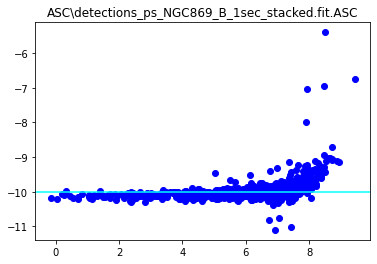

1484
1484
APASS_NGC869
(1484, 1)
-13.64803039020718


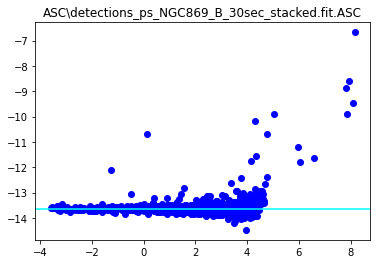

915
915
APASS_NGC869
(915, 1)
-11.68544862167576


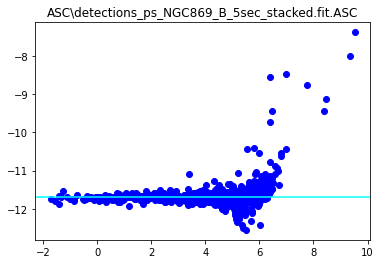

1997
1997
APASS_NGC869
(1997, 1)
-16.670243315366893


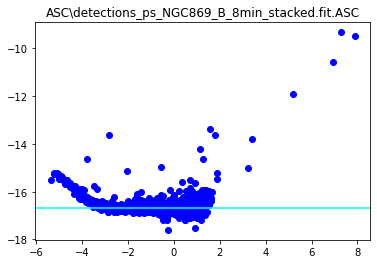

432
432
APASS_NGC869
(432, 1, 1)
-10.284066101537634


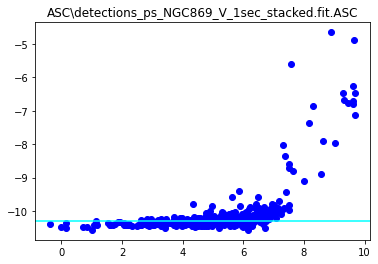

1464
1464
APASS_NGC869
(1464, 1, 1)
-13.921633844469426


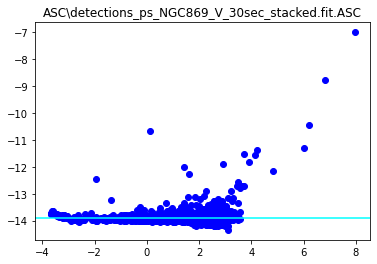

1899
1899
APASS_NGC869
(1899, 1, 1)
-16.382219784912714


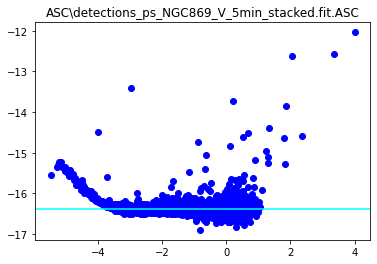

701
701
APASS_NGC869
(701, 1, 1)
-12.000209373896695


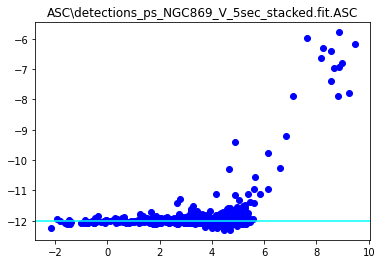

589
589
APASS_NGC884
(589, 1)
-9.93429089397275


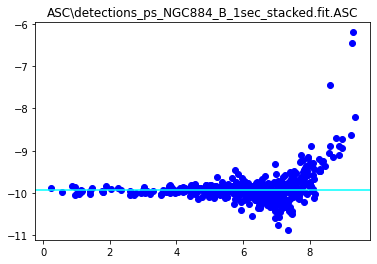

1404
1404
APASS_NGC884
(1404, 1)
-13.518551958188908


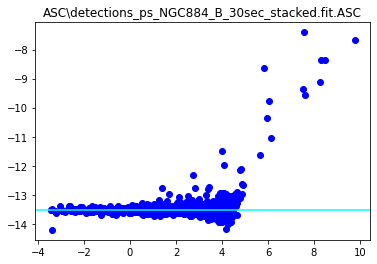

438
438
APASS_NGC884
(438, 1)
-11.619438194924545


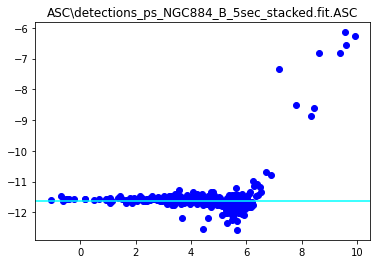

1931
1931
APASS_NGC884
(1931, 1)
-16.54438301519206


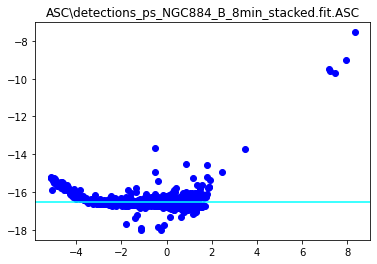

221
221
APASS_NGC884
(221, 1, 1)
-10.385640306011677


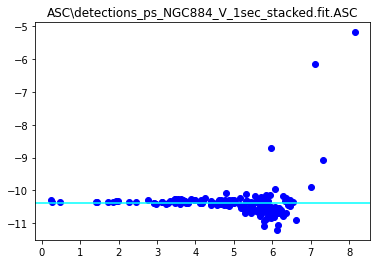

1376
1376
APASS_NGC884
(1376, 1, 1)
-13.860301171616115


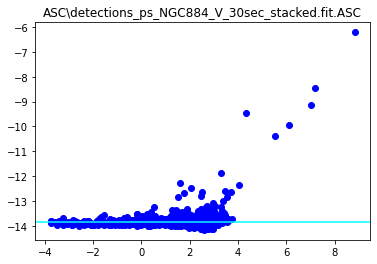

1853
1853
APASS_NGC884
(1853, 1, 1)
-16.387212785425977


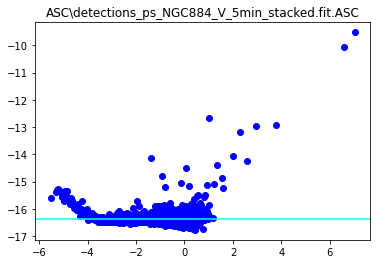

746
746
APASS_NGC884
(746, 1, 1)
-11.915768418157864


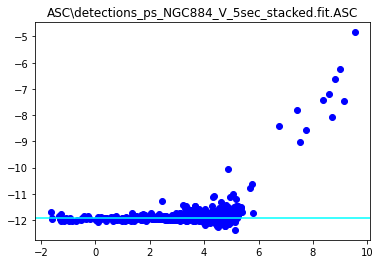

In [136]:
 new_mag = []
for i in ClusterP:
    if ClusterP[i].name == APASS['APASS_NGC869'].name[:6]:
        a = 'APASS_NGC869'
    elif ClusterP[i].name == APASS['APASS_NGC884'].name[:6]:
        a = 'APASS_NGC884'
    search_apass_index,search_star_index = crossmatch(APASS[a].ra,APASS[a].dec,ClusterP[i].star_ra_n,ClusterP[i].star_dec_n,3.)
    print(a)
    corr_mag,median_delt = plot_mag(ClusterP[i].mag_n, ClusterP[i].star_n, ClusterP[i].filter, ClusterP[i].filename, APASS[a],search_apass_index,search_star_index)
    new_mag.append(corr_mag)
    

In [138]:
new_mag=np.array(new_mag)
# print(new_mag[0])
for i in range(len(new_mag)):
    if len(new_mag[i].shape)==2:
        new_mag[i] = new_mag[i].flatten()
    print(new_mag[i].shape)
    # print(np.where(np.isnan(new_mag[i]==True)))

(4259,)
(12868,)
(7840,)
(19362,)
(4259,)
(12868,)
(19362,)
(7840,)
(3504,)
(11247,)
(6526,)
(18461,)
(3504,)
(11247,)
(18461,)
(6526,)


In [139]:
print(len(new_mag[0]-new_mag[4]))
print(len(new_mag[4]))

4259
4259


In [147]:
print(len(new_mag[3]),len(new_mag[7]))

19362 7840


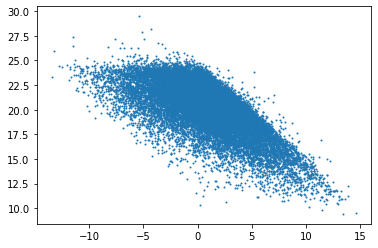

In [148]:
# plt.scatter(new_mag[0]-new_mag[4],new_mag[4],s=1)
# plt.scatter(new_mag[1]-new_mag[5],new_mag[5],s=1)
plt.scatter(new_mag[3]-new_mag[6],new_mag[6],s=1)

C:\Users\User\AppData\Local\Temp\ipykernel_18872\1464145561.py:21: RuntimeWarning: invalid value encountered in log10
  mag = -2.5*np.log10(self.data[:,17])


In [ ]:
search_apass_index,search_star_index = crossmatch(APASS_NGC869.ra,APASS_NGC869.dec,star_ra,star_dec,3.)
# f = open("testsearch_reg.txt", 'w')
# f.write('# Region file format: DS9 version 4.1\n')
# f.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\n')
# f.write('fk5\n')
# for i in search_apass_index:
#     f.write('circle('+str(APASS_NGC869.ra[i])+','+str(APASS_NGC869.dec[i])+',10.000")\n')
# f.close()


1890
1890


[ -9.96709208  -8.50216953 -10.10765695 ... -10.09604    -10.08091496
 -10.04273922]
-10.09279419439654


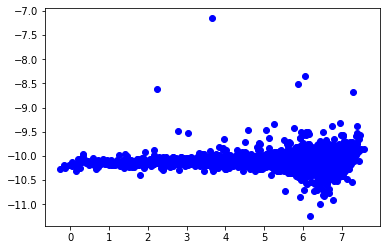

In [ ]:
mag_s = mag[star]
mag_s = np.transpose(mag_s[search_star_index])[0]
delt_B = mag_s-APASS_NGC869.B[search_apass_index]
plt.scatter(mag_s,delt_B,c='blue')
print(delt_B[np.where(np.isnan(delt_B)==False)])
print(np.median(delt_B[np.where(np.isnan(delt_B)==False)]))

In [ ]:
# NUMBER = []                               
# X_WORLD = []                
# Y_WORLD = []              
# X_IMAGE = []               
# Y_IMAGE = []                
# FLUX_APER1 = []
# FLUX_APER2 = [] 
# FLUX_APER3 = [] 
# FLUX_APER4 = [] 
# FLUX_APER5 = [] 
# FLUX_APER6 = []              
# FLUXERR_APER = []           
# FLUX_AUTO = []             
# FLUXERR_AUTO = []          
# A_WORLD = []              
# B_WORLD = []            
# THETA_J2000 = []
# FLAGS = []                                           
# FWHM_WORLD = []
# CLASS_STAR = []                                    
# FLUX_RADIUS = []

In [ ]:
# f = open(str(SEx_files[0])+"_reg.txt", 'w')
# f.write('# Region file format: DS9 version 4.1\n')
# f.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\n')
# f.write('fk5\n')
# for i in range(len(star)):
#     f.write('circle('+str(numeric_data[star,1])+','+str(numeric_data[star,2])+',1.500")\n')
# f.close()

In [ ]:

print(numeric_data[star,17])
print(mag[star])
print(numeric_data[star,1])
# print(np.where([numeric_data[star,2]>=57.122187-0.015 and numeric_data[star,2]<=57.122187+0.015,numeric_data[star,1]>=34.70509-0.01, numeric_data[star,1]<=34.70509+0.01 ]))            

[0.00192867 0.7410884  0.157098   ... 0.00732987 0.0502109  0.02473488]
[6.78685744 0.32532496 2.00957336 ... 5.33725962 3.24800499 4.01672548]
[34.3379466  34.45124197 34.45531254 ... 35.01596392 35.14734456
 34.13293505]


C:\Users\User\AppData\Local\Temp\ipykernel_18872\3431625057.py:3: RuntimeWarning: invalid value encountered in log10
  mag = -2.5*np.log10(numeric_data[:,17])


In [ ]:
df = pd.read_csv(r"C:\Users\User\Downloads\apass_34.771_57.146_0.4.csv")
print(df.info())
df2 = df.dropna(subset=['radeg','decdeg'])
data = (df2.to_numpy())
f = open("APASS_869_reg.txt", 'w')
f.write('# Region file format: DS9 version 4.1\n')
f.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\n')
f.write('fk5\n')
for i in range(len(data[:,0])):
    f.write('circle('+str(data[i,0])+','+str(data[i,2])+',3.000")\n')
f.close()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4136 entries, 0 to 4135
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   radeg            4136 non-null   float64
 1   raerr(")         4136 non-null   float64
 2   decdeg           4136 non-null   float64
 3   decerr(")        4136 non-null   float64
 4   Johnson_V (V)    3427 non-null   float64
 5   Verr             3427 non-null   float64
 6   Vnobs            4136 non-null   int64  
 7   Johnson_B (B)    3434 non-null   float64
 8   Berr             3434 non-null   float64
 9   Bnobs            4136 non-null   int64  
 10  Sloan_u (SU)     0 non-null      float64
 11  SUerr            0 non-null      float64
 12  SUnobs           4136 non-null   int64  
 13  Sloan_g (SG)     3967 non-null   float64
 14  SGerr            3967 non-null   float64
 15  SGnobs           4136 non-null   int64  
 16  Sloan_r (SR)     3928 non-null   float64
 17  SRerr         